In [1382]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import pickle
import scipy
from scipy.sparse import csc_matrix
from collections import defaultdict
from os import listdir
import matplotlib.pyplot as plt
import sys
import gc
%matplotlib inline

In [2]:
with open('./../PickleFiles/num_to_ind_shot.pkl','r') as pickleFile:
    num_to_ind = pickle.load(pickleFile)

with open('./../PickleFiles/ind_to_num_shot.pkl','r') as pickleFile:
    ind_to_num = pickle.load(pickleFile)
    
with open('./../PickleFiles/player_names.pkl','r') as pickleFile:
    num_to_name = pickle.load(pickleFile)

with open('./../PickleFiles/tourn_order.pkl','r') as pickleFile:
    tourn_order = pickle.load(pickleFile)
    
name_to_num = {value:key for key,value in num_to_name.iteritems()}

In [3]:
rdata = pd.read_csv('./../data/round.csv')

In [4]:
cols = ['Year','Permanent_Tournament_#']
data = pd.concat([pd.read_csv('./../data/%d.csv' % (year))[cols] for year in range(2003,2017)])

In [5]:
data = pd.concat([data[(data.Year==year) & (data['Permanent_Tournament_#']==tourn)] 
                  for year,tourn in tourn_order])
tups = data.drop_duplicates(['Year','Permanent_Tournament_#'])[['Year','Permanent_Tournament_#']].values.tolist()

In [6]:
data = None
gc.collect()

25

In [7]:
tournament_groups = {tuple(tup):u/4 for u,tup in enumerate(tups)}

In [8]:
cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
        'rough375','fairway0','fairway300','fairway540','bunker','other']

Selecting most predictive for first 50 tournament groups

In [1378]:
mypath = './../ranks/'
corrs = defaultdict(list)
for path in [f for f in listdir(mypath)]:
    if len([f for f in listdir(mypath+path)])!=28:
        continue
    ratings_adam = {}
    for cat in cats:
        ratings_adam[cat] = np.load('%s%s/%s_ranks.npy' % (mypath,path,cat))
    preds,outcomes = defaultdict(list),defaultdict(list)
    for year,tourn in tups:
        tournament_group = tournament_groups[(year,tourn)]
        if tournament_group<38 or tournament_group>87:
            continue
        rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
        players = pd.unique(rtourn.Player_Number)
        finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
        finishing_positions = np.array([finishing_positions[player] for player in players])
        players = [num_to_ind[player] for player in players]
        for cat in cats:
            ratings = ratings_adam[cat][players,tournament_group-1]
            nulls = np.isnan(ratings)
            if np.all(nulls):
                continue
            ranking = pd.Series(ratings[~nulls]).rank(ascending=False,pct=True)
            outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
            preds[cat].extend(ranking.tolist())
            outcomes[cat].extend(outcome.tolist())
    for cat in cats:
        corrs[cat].extend([(path,np.corrcoef(preds[cat],outcomes[cat])[0,1])])
ratings_adam,reps_adam = {},{}
for cat in corrs:
    print cat
    for params,corr in sorted(corrs[cat],key=lambda x: x[1],reverse=True):
        print params,corr
    best = sorted(corrs[cat],key=lambda x: x[1],reverse=True)[0][0]
    ratings_adam[cat] = np.load('%s%s/%s_ranks.npy' % (mypath,best,cat))
    reps_adam[cat] = np.load('%s%s/%s_reps.npy' % (mypath,best,cat))

green5
ranks-300-0.45-0.65-0.5-0.999-25 0.0403923967265
ranks-300-0.45-0.65-0.5-0.999-30 0.040298446563
ranks-300-0.99-0.99-0.99-0.99-26 0.0402331814618
ranks-300-0.3-0.55-0.6-0.999-23.5 0.040199420628
ranks-300-0.3-0.55-0.6-0.999-22.5 0.0401702805254
ranks-300-0.99-0.99-0.99-0.99-25 0.0401156447149
ranks-300-0.99-0.99-0.99-0.99-19.5 0.0400945165817
ranks-300-0.99-0.99-0.99-0.99-24.5 0.0400901340638
ranks-300-0.3-0.55-0.6-0.999-21.5 0.0400886125223
ranks-300-0.23-0.15-0.7-0.99-33 0.0400825041612
ranks-300-0.99-0.99-0.99-0.99-24 0.0400789857317
ranks-300-0.99-0.99-0.99-0.99-23.5 0.0400606397522
ranks-300-0.99-0.99-0.99-0.99-25.5 0.0400414723488
ranks-300-0.99-0.99-0.99-0.99-19 0.0400029295463
ranks-300-0.99-0.99-0.99-0.99-23 0.0399668361334
ranks-300-0.23-0.15-0.7-0.99-31 0.039961871678
ranks-300-0.45-0.65-0.5-0.999-21 0.0399429522303
ranks-300-0.99-0.99-0.99-0.99-18.5 0.0399296991797
ranks-300-0.99-0.99-0.99-0.99-20 0.0399268354791
ranks-300-0.99-0.99-0.99-0.99-22.5 0.0398715702548
ran

In [1052]:
mypath = './../Broadie_Aves'
corrs = defaultdict(list)
for BETA in range(1,51):
    ratings_broadie = {}
    for cat in cats:
        ratings_broadie[cat] = np.load('%s/%s_%d.npy' % (mypath,cat,BETA))
    preds,outcomes = defaultdict(list),defaultdict(list)
    for year,tourn in tups:
        tournament_group = tournament_groups[(year,tourn)]
        if tournament_group<38 or tournament_group>87:
            continue
        rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
        players = pd.unique(rtourn.Player_Number)
        finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
        finishing_positions = np.array([finishing_positions[player] for player in players])
        players = [num_to_ind[player] for player in players]
        for cat in cats:
            ratings = ratings_broadie[cat][players,tournament_group]
            nulls = np.isnan(ratings)
            if np.all(nulls):
                continue
            ranking = pd.Series(ratings[~nulls]).rank(ascending=False,pct=True)
            outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
            preds[cat].extend(ranking.tolist())
            outcomes[cat].extend(outcome.tolist())
    for cat in cats:
        corrs[cat].extend([(BETA,np.corrcoef(preds[cat],outcomes[cat])[0,1])])
ratings_broadie,reps_broadie = {},{}
for cat in corrs:
    print cat
    for BETA,corr in sorted(corrs[cat],key=lambda x: x[1],reverse=True):
        print BETA,corr
    best = sorted(corrs[cat],key=lambda x: x[1],reverse=True)[0][0]
    ratings_broadie[cat] = np.load('%s/%s_%d.npy' % (mypath,cat,best))
    reps_broadie[cat] = np.load('%s/%s_%dG.npy' % (mypath,cat,best))

green5
41 0.0317742953702
40 0.0317716360923
47 0.031747755901
48 0.0317446481207
49 0.0317429759365
44 0.0317323456071
42 0.0317217882936
45 0.0317210691178
39 0.0317207592068
43 0.031707339667
46 0.0317065774633
50 0.0316897328961
33 0.0316719136869
37 0.0316672127529
32 0.0316661003748
34 0.0316495741865
38 0.0316376385913
36 0.0316312559213
35 0.0316248614455
31 0.0316097812565
28 0.0315363937395
30 0.0315347075103
26 0.0314938907975
29 0.0314855480917
20 0.0314634811306
22 0.0314468860311
27 0.0314458976539
25 0.0313786816325
21 0.0313781667369
24 0.0313437610273
19 0.0313314676439
23 0.0313278376749
18 0.0312082453963
17 0.0308130002117
15 0.0305943848488
16 0.0305329366915
14 0.0300602961398
13 0.0294440052564
12 0.0288114120834
11 0.0280219307606
2 0.027610725241
10 0.026891440089
3 0.0266692044507
4 0.0262857021588
5 0.0260902941637
9 0.0259428813514
8 0.0255541383671
1 0.0254797712005
6 0.0248961157014
7 0.0248518309322
fairway300
32 0.0837295994037
31 0.0837147990975
33 0.08

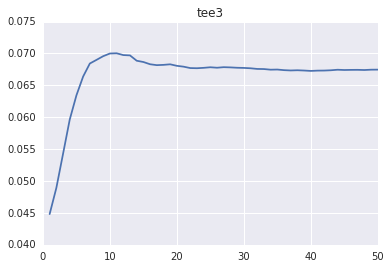

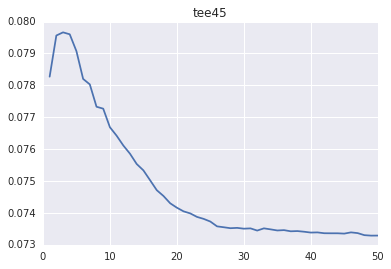

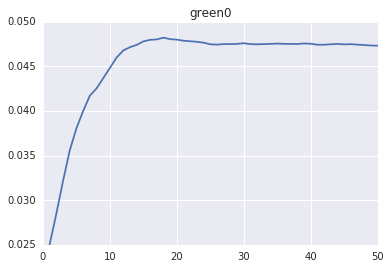

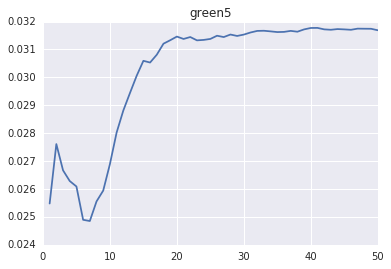

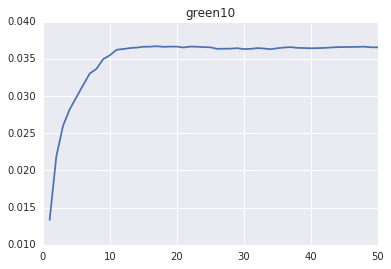

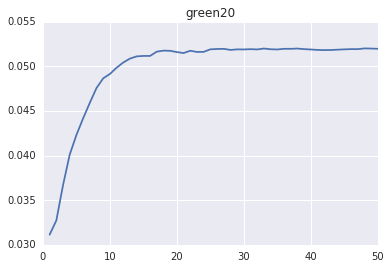

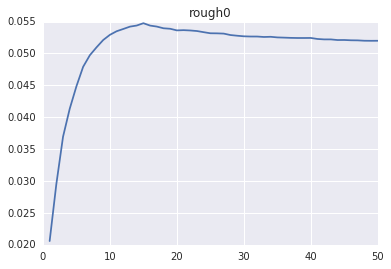

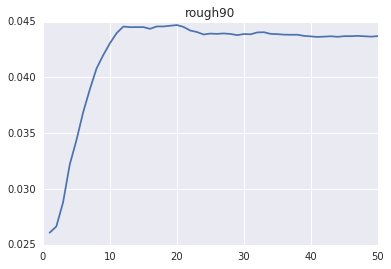

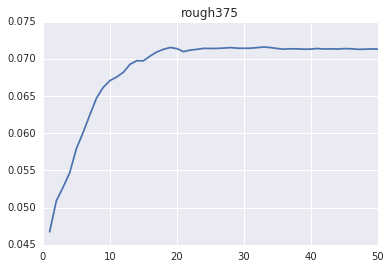

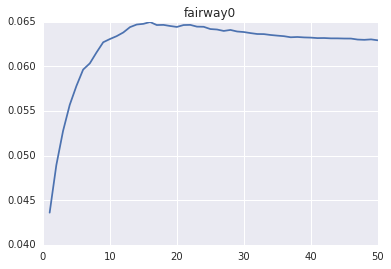

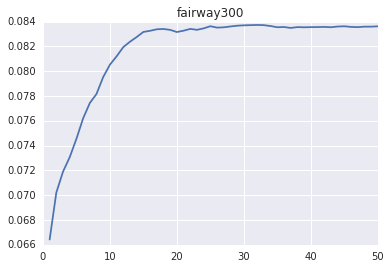

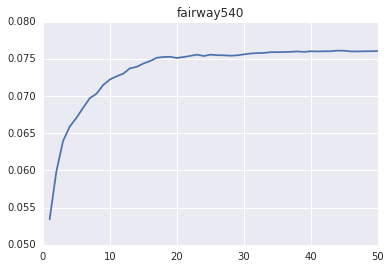

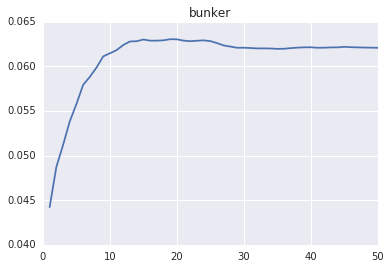

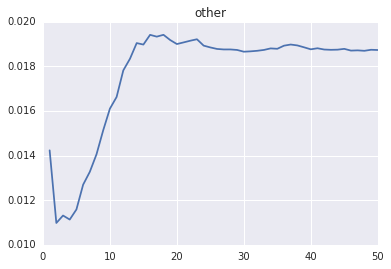

In [701]:
for cat in cats:
    plt.figure()
    x,y = zip(*corrs[cat])
    plt.plot(x,y)
    plt.title(cat)

Test set predictions

In [1258]:
preds_a,preds_b,outcomes = defaultdict(list),defaultdict(list),defaultdict(list)
for year,tourn in tups:
    tournament_group = tournament_groups[(year,tourn)]
    if tournament_group<88:
        continue
    rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
    players = pd.unique(rtourn.Player_Number)
    finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
    finishing_positions = np.array([finishing_positions[player] for player in players])
    players = np.array([num_to_ind[player] for player in players])
    for cat in cats:
        ratings_a = ratings_adam[cat][players,tournament_group-1]
        ratings_b = ratings_broadie[cat][players,tournament_group]
        nulls = np.logical_or(np.isnan(ratings_a),np.isnan(ratings_b))
        if np.all(nulls):
            continue
        rankings_a = pd.Series(ratings_a[~nulls]).rank(ascending=False,pct=True)
        rankings_b = pd.Series(ratings_b[~nulls]).rank(ascending=False,pct=True)
        outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
        preds_a[cat].extend(rankings_a.tolist())
        preds_b[cat].extend(rankings_b.tolist())
        outcomes[cat].extend(outcome.tolist())

Correlation tests

In [1259]:
corrs = {cat:np.corrcoef(preds_b[cat],outcomes[cat])[0,1] for cat in cats}

In [1260]:
ps_and_os = {}
for cat in cats:
    ps_and_os[cat] = pd.DataFrame({'Predictions_Adam':preds_a[cat],
                                   'Predictions_Broadie':preds_b[cat],
                                   'Outcome':outcomes[cat]})

In [1261]:
for cat in cats:
    print
    print cat
    print len(preds_a[cat])
    assert len(preds_a[cat])==len(preds_b[cat])
    print 'Adam Corr = ' + str(np.corrcoef(preds_a[cat],outcomes[cat])[0,1])
    print 'Broadie Corr = ' + str(np.corrcoef(preds_b[cat],outcomes[cat])[0,1])
    #print 'Ave Corr = ' + str(np.corrcoef((np.array(preds_a[cat])+np.array(preds_b[cat]))/2,outcomes[cat])[0,1])
    print 


tee3
24147
Adam Corr = 0.0982799448857
Broadie Corr = 0.0883652772141


tee45
24095
Adam Corr = 0.116846431357
Broadie Corr = 0.106354598938


green0
24147
Adam Corr = 0.0455657039892
Broadie Corr = 0.0366799770574


green5
24147
Adam Corr = 0.0249064333747
Broadie Corr = 0.0169719480408


green10
24147
Adam Corr = 0.0446811841225
Broadie Corr = 0.0334820350513


green20
24147
Adam Corr = 0.0444306408142
Broadie Corr = 0.0394179332057


rough0
24135
Adam Corr = 0.0447105076368
Broadie Corr = 0.0350812080657


rough90
24123
Adam Corr = 0.051236534814
Broadie Corr = 0.0473352937577


rough375
24147
Adam Corr = 0.08712725745
Broadie Corr = 0.0726519657294


fairway0
24143
Adam Corr = 0.0719891305628
Broadie Corr = 0.0691534469134


fairway300
24146
Adam Corr = 0.0785977758151
Broadie Corr = 0.0723335161742


fairway540
24139
Adam Corr = 0.0896759519945
Broadie Corr = 0.0826041483787


bunker
24143
Adam Corr = 0.0445270746206
Broadie Corr = 0.0384112043822


other
14257
Adam Corr = 0.0139

In [1375]:
def confidence_interval(df,its):
    diff_corrs = []
    for _ in range(its):
        df_ = df.sample(frac=1,replace=True)
        diff_corrs.append(np.corrcoef(df_.Predictions_Adam,df_.Outcome)[0,1] - np.corrcoef(df_.Predictions_Broadie,df_.Outcome)[0,1])
    return diff_corrs

In [1377]:
for cat in cats:
    diff_corrs = confidence_interval(ps_and_os[cat],10000)
    print cat
    print 'diff', np.percentile(diff_corrs,q=[2.5,97.5])

tee3
diff [ 0.00564972  0.01424088]
tee45
diff [ 0.00566745  0.01532964]
green0
diff [ 0.00526642  0.01247718]
green5
diff [ 0.00303948  0.01276369]
green10
diff [ 0.00562005  0.01676398]
green20
diff [-0.00105913  0.01097478]
rough0
diff [ 0.00120644  0.01822214]
rough90
diff [-0.00650625  0.01443186]
rough375
diff [ 0.00580925  0.02318234]
fairway0
diff [-0.00431608  0.00996725]
fairway300
diff [ 0.00153069  0.01079865]
fairway540
diff [ 0.00182336  0.0122213 ]
bunker
diff [-0.00018612  0.01251575]
other
diff [-0.04085419 -0.00105525]


In [330]:
sys.path.insert(0, '/home/ubuntu/CorrelationStats/')
import corrstats

(-0.89127990476054142, 0.37491851749125571)
(1.0171097212822693, 0.30910123623869312)


In [1264]:
for cat in cats:
    xy = np.corrcoef(ps_and_os[cat].Outcome,ps_and_os[cat].Predictions_Adam)[0,1]
    xz = np.corrcoef(ps_and_os[cat].Outcome,ps_and_os[cat].Predictions_Broadie)[0,1]
    yz = np.corrcoef(ps_and_os[cat].Predictions_Adam,ps_and_os[cat].Predictions_Broadie)[0,1]
    print cat
    print xy,xz,yz
    print corrstats.dependent_corr(xy,xz,yz,len(ps_and_os[cat]),
                                    twotailed=False, conf_level=0.95, method='steiger')
    print corrstats.dependent_corr(xy,xz,yz,len(ps_and_os[cat]),
                                    twotailed=False, conf_level=0.95, method='zou')
    print

tee3
0.0982799448857 0.0883652772141 0.941851188881
(4.5398087229593047, 2.8288522917474523e-06)
(0.0056325239563371574, 0.014196596755150313)

tee45
0.116846431357 0.106354598938 0.927241265855
(4.2985087601542116, 8.6312985503322892e-06)
(0.0057062533357474391, 0.015277211771734436)

green0
0.0455657039892 0.0366799770574 0.959273522766
(4.8442899197005573, 6.3926275983838821e-07)
(0.0052889761225145809, 0.012482141598406276)

green5
0.0249064333747 0.0169719480408 0.92778170249
(3.2454739896290743, 0.00058707474934804882)
(0.0031418759849768671, 0.0127266267176405)

green10
0.0446811841225 0.0334820350513 0.901634669414
(3.9277204556067979, 4.2996590014832137e-05)
(0.0056090613127919731, 0.016788496294264186)

green20
0.0444306408142 0.0394179332057 0.888244221398
(1.6491297250914869, 0.049567035346986588)
(-0.00094497259665536626, 0.010970034843736005)

rough0
0.0447105076368 0.0350812080657 0.776193723967
(2.238050806525536, 0.012613413391868722)
(0.0011958218924570576, 0.01806178

Plotting

In [1379]:
inds_to_plot = [num_to_ind[name_to_num[name]] for name in ['Weir, Mike','Johnson, Dustin']]#['Singh, Vijay','Els, Ernie','Mickelson, Phil']]
#                                                            'Johnson, Dustin','Mickelson, Phil',,
#                                                            ,'Simpson, Webb',]]

In [1380]:
from scipy.interpolate import UnivariateSpline
years = set()
group_to_year = {}
for year,tourn in tups:
    if year not in years:
        tournament_group = tournament_groups[(year,tourn)]
        group_to_year[tournament_group] = year
        years.add(year)
x = group_to_year.keys()
y = [group_to_year[key] for key in group_to_year.keys()]
spl = UnivariateSpline(x,y)
years = [int(__builtins__.round(num)) for num in spl(np.arange(138))]

In [1089]:
pd.Series(reps_broadie['tee45'][:,137]).rank(ascending=False)[1301]

155.0

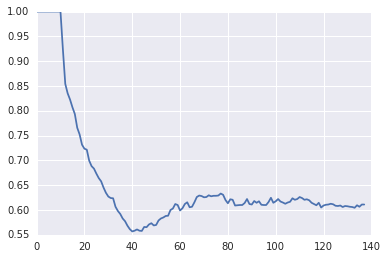

In [1085]:
plt.plot(np.arange(138),[np.isnan(reps_broadie['tee45'][:,group]).sum()/1990. for group in np.arange(138)])

In [1254]:
group_to_year

{0: 2003,
 10: 2004,
 21: 2005,
 31: 2006,
 42: 2007,
 52: 2008,
 62: 2009,
 72: 2010,
 82: 2011,
 91: 2012,
 100: 2013,
 109: 2014,
 118: 2015,
 127: 2016}

In [1255]:
for cat in cats:
    print '*************' + cat + '*************'
    reps = np.copy(reps_broadie[cat][:,51])
    num_nans = np.isnan(reps).sum()
    top_200 = set(np.argsort(reps)[-(num_nans+200):-num_nans])
    top_200 = np.array([u not in top_200 for u in range(reps.shape[0])])
    if cat=='other':
        ratings = np.copy(ratings_broadie[cat][:,51])
    else:
        ratings = np.copy(ratings_adam[cat][:,51])
    ratings[top_200] = np.nan
    num_nans = np.isnan(ratings).sum()
    inds = np.argsort(ratings)[-(num_nans+10):-num_nans][::-1]
    names = [num_to_name[ind_to_num[ind]] for ind in inds]
    ratings = ratings[inds]
    df = pd.DataFrame({'name':names,'ratings':ratings})
    df.index = range(1,11)
    print df

*************tee3*************
               name   ratings
1      Woods, Tiger  0.968851
2       Lehman, Tom  0.964271
3    Mediate, Rocco  0.962658
4   Mickelson, Phil  0.962537
5      Kim, Anthony  0.962041
6        Funk, Fred  0.960293
7        Els, Ernie  0.959408
8       Bohn, Jason  0.959051
9     Quinney, Jeff  0.958275
10   Campbell, Chad  0.958251
*************tee45*************
                name   ratings
1       Holmes, J.B.  0.980879
2      Watson, Bubba  0.978339
3       Weekley, Boo  0.978090
4   Wetterich, Brett  0.976102
5    Warren, Charles  0.974513
6    Allenby, Robert  0.974361
7        Scott, Adam  0.973979
8      Mahan, Hunter  0.973958
9        Durant, Joe  0.973870
10     Glover, Lucas  0.973831
*************green0*************
                   name   ratings
1      Snedeker, Brandt  1.000581
2         Kresge, Cliff  1.000572
3      Parnevik, Jesper  1.000433
4       Sabbatini, Rory  1.000281
5   Johnson, Richard S.  1.000176
6            Crane, Ben  1.00

In [1299]:
reps = np.copy(reps_adam[cat])

In [1300]:
reps.shape

(1990, 138)

In [1308]:
inds_to_plot

[240]

In [1309]:
top_200[240].sum()

66

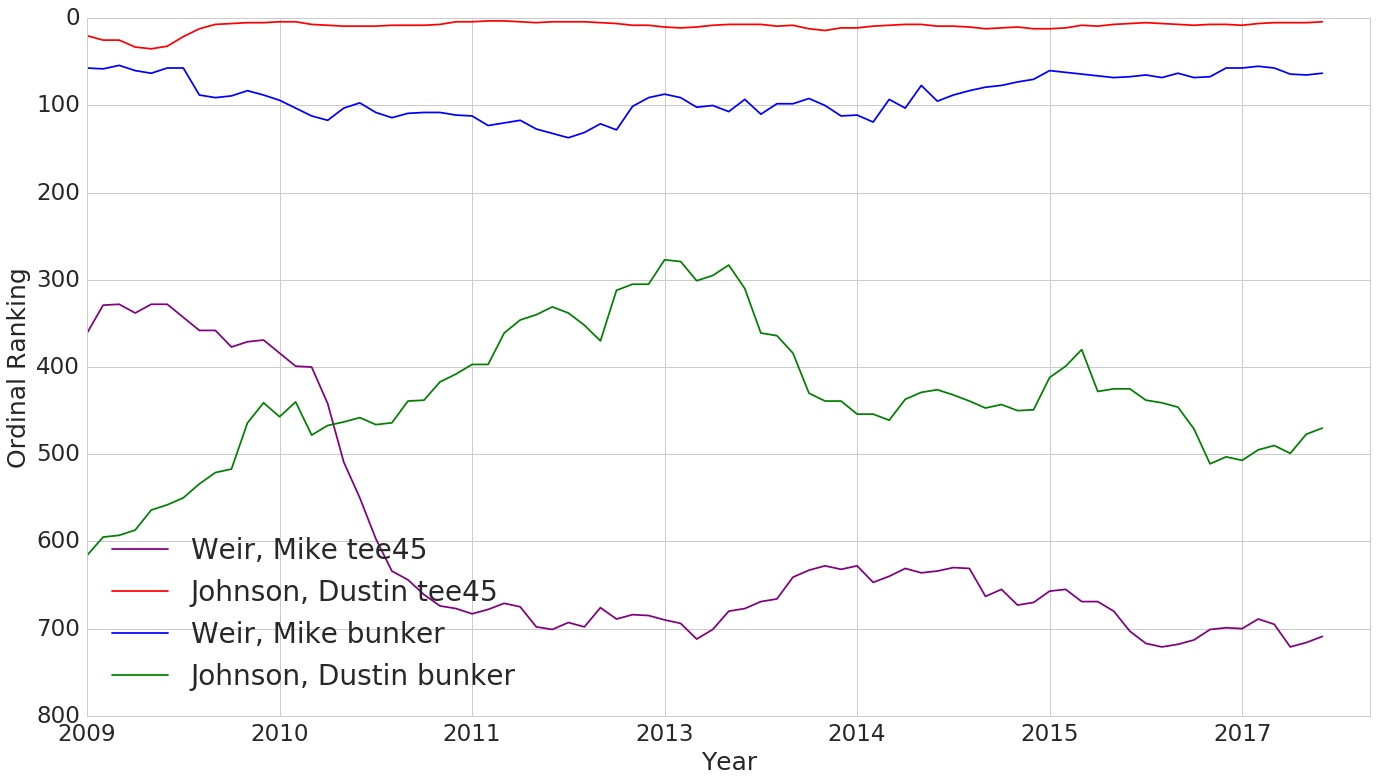

In [1385]:
fig, ax = plt.subplots(1,1, figsize=(23,12.5))
color_map = {0:'purple',1:'red',2:'blue',3:'green'}
for u,cat in enumerate(['tee45','bunker']):
    reps = np.copy(reps_adam[cat])
    reps = pd.DataFrame(reps).rank(ascending=False).values
    top_200 = reps<=200
    rating1 = np.copy(ratings_adam[cat])
    #rating1[top_200] = np.nan
    ranking1 = pd.DataFrame(rating1).rank(ascending=False).values
    #rating2 = np.copy(ratings_broadie[cat])
    #rating2[top_200] = np.nan
    #ranking2 = pd.DataFrame(rating2).rank(ascending=False).values
    for u1,ind in enumerate(inds_to_plot):
        plt.plot(np.arange(ratings_adam[cat].shape[1])[60:],ranking1[ind][60:],c=color_map[u*2+u1],label=num_to_name[ind_to_num[ind]] + ' ' + cat)
        #plt.plot(np.arange(ratings_adam[cat].shape[1]),ranking2[ind],label=num_to_name[ind_to_num[ind]] + ' Strokes Gained to the Field')

         
plt.legend(loc=3,prop={'size':28})
#plt.title(cat+'ranking',fontsize=24)
plt.xticks(np.arange(ratings_adam[cat].shape[1])[60:][::12],years[60:][::12])
plt.setp(ax.get_xticklabels(), fontsize=23);
plt.setp(ax.get_yticklabels(), fontsize=23);
plt.gca().invert_yaxis()
plt.ylabel('Ordinal Ranking',fontsize=25)
plt.xlabel('Year',fontsize=25)
plt.savefig('./../Plots/WeirJohnson.png',dpi=100)

Regression

In [1265]:
preds_a,preds_b,outcomes = defaultdict(list),defaultdict(list),[]
for year,tourn in tups:
    tournament_group = tournament_groups[(year,tourn)]
    if tournament_group<88:
        continue
    rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
    players = pd.unique(rtourn.Player_Number)
    finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
    finishing_positions = np.array([finishing_positions[player] for player in players])
    players = np.array([num_to_ind[player] for player in players])
    nulls = [False]*players.shape[0]
    for cat in cats+['reps']:
        if cat=='reps':
            ratings_a = np.array([reps_broadie[c][players,tournament_group] for c in cats]).mean(0)
            ratings_b = np.array([reps_broadie[c][players,tournament_group] for c in cats]).mean(0)
            nulls_ = np.logical_or(np.isnan(ratings_a),np.isnan(ratings_b))
            nulls = np.logical_or(nulls,nulls_)
            continue
        elif cat=='other':
            ratings_a = ratings_broadie[cat][players,tournament_group]
        else:
            ratings_a = ratings_adam[cat][players,tournament_group-1]
        ratings_b = ratings_broadie[cat][players,tournament_group]
        nulls_ = np.logical_or(np.isnan(ratings_a),np.isnan(ratings_b))
        nulls = np.logical_or(nulls,nulls_)
    for cat in cats+['reps']:
        if cat=='reps':
            ratings_a = np.array([reps_broadie[c][players,tournament_group] for c in cats]).mean(0)[~nulls]
            ratings_b = np.array([reps_broadie[c][players,tournament_group] for c in cats]).mean(0)[~nulls]
            rankings_a = pd.Series(ratings_a).rank(ascending=False,pct=True)
            rankings_b = pd.Series(ratings_b).rank(ascending=False,pct=True)
            preds_a[cat].extend(rankings_a.tolist())
            preds_b[cat].extend(rankings_b.tolist())
            continue
        elif cat=='other':
            ratings_a = ratings_broadie[cat][players,tournament_group][~nulls]
        else:
            ratings_a = ratings_adam[cat][players,tournament_group-1][~nulls]
        ratings_b = ratings_broadie[cat][players,tournament_group][~nulls]
        rankings_a = pd.Series(ratings_a).rank(ascending=False,pct=True)
        rankings_b = pd.Series(ratings_b).rank(ascending=False,pct=True)
        preds_a[cat].extend(rankings_a.tolist())
        preds_b[cat].extend(rankings_b.tolist())
    outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
    outcomes.extend(outcome.tolist())

In [1164]:
X_sgttf = np.column_stack([preds_b[cat] for cat in cats])
X_network = np.column_stack([preds_a[cat] for cat in cats])
y = np.array(outcomes)

In [1165]:
X_sgttf.shape,X_network.shape,y.shape

((23650, 14), (23650, 14), (23650,))

In [1166]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

In [1167]:
ols = LinearRegression()

In [1134]:
(cross_val_score(ols,X_sgttf,y,cv=30,scoring='mean_absolute_error').mean(),
 cross_val_score(ols,X_network,y,cv=30,scoring='mean_absolute_error').mean(),
 cross_val_score(ols,(X_sgttf+X_network)/2,y,cv=30,scoring='mean_absolute_error').mean())

(-0.24393550869816044, -0.24385870440456528, -0.24368270328988523)

In [1135]:
(cross_val_score(ols,X_sgttf,y,cv=30).mean(),
 cross_val_score(ols,X_network,y,cv=30).mean(),
 cross_val_score(ols,(X_sgttf+X_network)/2,y,cv=30).mean())

(0.034269417345546831, 0.03495177669012238, 0.036002277728058182)

In [1136]:
ols.fit(X_sgttf,y)
ols.score(X_sgttf,y)

0.035803383589916971

Other regressions using just the Network method

In [1267]:
with open('./../PickleFiles/course_profiles.pkl','r') as pickleFile:
    course_profiles = pickle.load(pickleFile)

with open('./../PickleFiles/course_order.pkl','r') as pickleFile:
    course_order = pickle.load(pickleFile)

cat_map = {''.join([c for c in name.lower() if c!='-']):name for name in course_profiles.keys()}

In [1268]:
preds,outcomes = defaultdict(list),[]
course_profs = defaultdict(list)
years,tourns = [],[]
for year,tourn in tups:
    tournament_group = tournament_groups[(year,tourn)]
    if tournament_group<88:
        continue
    rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
    courses = pd.unique(rtourn['Course_#'])
    players = pd.unique(rtourn.Player_Number)
    finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
    finishing_positions = np.array([finishing_positions[player] for player in players])
    players = np.array([num_to_ind[player] for player in players])
    nulls = np.array([False]*players.shape[0])
    for cat in cats+['reps']:
        if cat=='reps':
            ratings = np.array([reps_adam[c][players,tournament_group] for c in cats]).mean(0)
        elif cat=='other':
            ratings = ratings_broadie[cat][players,tournament_group]
        else:
            ratings = ratings_adam[cat][players,tournament_group-1]
        nulls = np.logical_or(nulls,np.isnan(ratings))
    for cat in cats+['reps']:
        if cat=='reps':
            ratings = np.array([reps_adam[c][players,tournament_group] for c in cats]).mean(0)[~nulls]
        elif cat=='other':
            ratings = ratings_broadie[cat][players,tournament_group][~nulls]
        else:
            ratings = ratings_adam[cat][players,tournament_group-1][~nulls]
        rankings = pd.Series(ratings).rank(ascending=False,pct=True)
        preds[cat].extend(rankings.tolist())
        if cat!='reps':
            course_profs[cat].extend([np.mean([course_profiles[cat_map[cat]][course_order.index(course),tournament_group] 
                                           for course in courses])]*rankings.shape[0])
    outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
    outcomes.extend(outcome.tolist())
    years.extend([year]*outcome.shape[0])
    tourns.extend([tourn]*outcome.shape[0])

In [1269]:
d = {cat+'_rank':preds[cat] for cat in cats+['reps']}
d.update({cat+'_importance':course_profs[cat] for cat in cats})
d.update({'Outcome':outcomes,'Year':years,'Tournament':tourns})
mat = pd.DataFrame(d)

In [1270]:
groups = {tuple(tup):u for u,tup in enumerate(mat[['Tournament','Year']].drop_duplicates().values.tolist())}
groups = np.array([groups[tuple(tup)] for tup in mat[['Tournament','Year']].values.tolist()])
n_groups = len(pd.unique(groups))

In [1274]:
X = mat[[col for col in mat.columns if 'rank' in col and 'reps' not in col]]
y = mat.Outcome.values

In [1275]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

In [1276]:
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     64.09
Date:                Fri, 02 Dec 2016   Prob (F-statistic):          5.56e-179
Time:                        17:47:16   Log-Likelihood:                -3685.1
No. Observations:               23650   AIC:                             7400.
Df Residuals:                   23635   BIC:                             7521.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.2617      0.009     

In [1157]:
np.abs((y - y.mean())).mean()

0.24957940093164396

In [1160]:
y.mean()

0.50416490486257926

In [1158]:
-1*cross_val_score(ols,X,y,cv=30,scoring='mean_absolute_error').mean()

0.24387534705608271

In [1147]:
cross_val_score(ols,X,y,cv=30).mean()

0.034854907795094946

In [650]:
X.shape

(24044, 13)

In [653]:
ols.fit(X,y)
ols.coef_

array([ 0.0208577 ,  0.03668521,  0.0360497 ,  0.01540513,  0.0507506 ,
        0.02703503,  0.02919014,  0.01052584,  0.02641833,  0.03332379,
        0.02817498,  0.04705884,  0.11681252])

In [655]:
ols.fit(X,y)
ols.coef_

array([ 0.0181664 ,  0.03586536,  0.05486376,  0.02762472,  0.06990629,
        0.12858355, -0.00222165, -0.00735313,  0.02932187,  0.04615132,
        0.02026738,  0.04777444,  0.06928941,  0.01441933,  0.00459329,
       -0.06791474, -0.06925632, -0.08884165, -0.3360938 ,  0.12473628,
        0.05842419, -0.01701896, -0.06578394,  0.06437375, -0.00223911,
        0.18222897])

In [654]:
X = np.hstack((mat[[col for col in mat.columns if 'rank' in col]].values,
               np.multiply(mat[[col for col in mat.columns if 'rank' in col]].values,
                           mat[[col for col in mat.columns if 'importance' in col]].values)))
y = mat.Outcome.values

In [450]:
from sklearn.linear_model import LassoCV,RidgeCV

In [451]:
rcv.fit(X,y)

RidgeCV(alphas=array([  1.00000e-05,   3.59381e-05,   1.29155e-04,   4.64159e-04,
         1.66810e-03,   5.99484e-03,   2.15443e-02,   7.74264e-02,
         2.78256e-01,   1.00000e+00]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [452]:
rcv.cv_values_.mean(0)

array([ 0.08011617,  0.08011617,  0.08011617,  0.08011615,  0.08011611,
        0.08011594,  0.08011536,  0.08011339,  0.0801076 ,  0.08009479])

In [453]:
for col,coef in sorted(zip([col for col in mat.columns if '_rank' in col],rcv.coef_),key=lambda x: x[1])[::-1]:
    print col,coef

tee45_rank 0.0784227681245
green10_rank 0.0774886750685
green0_rank 0.0611639389567
tee3_rank 0.0520549333138
fairway300_rank 0.0506583304915
rough375_rank 0.0402129431372
fairway0_rank 0.0354005226466
rough0_rank 0.0284595802312
fairway540_rank 0.0237387440325
rough90_rank 0.0216585712191
bunker_rank 0.0199474341284
green20_rank 0.0158628832721
green5_rank 0.00877962457956


In [454]:
pd.Series(rcv.predict(X)).describe()

count    24044.000000
mean         0.504097
std          0.055188
min          0.312114
25%          0.467663
50%          0.505595
75%          0.541207
max          0.732678
dtype: float64

In [1203]:
lcv = LassoCV(eps=0.001, n_alphas=10000, alphas=None, 
              fit_intercept=True, normalize=True, 
              precompute='auto', max_iter=1000, tol=0.0001, 
              copy_X=True, cv=None, verbose=False)

In [1204]:
lcv.fit(X,y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=10000, n_jobs=1, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [1205]:
lcv.alpha_

3.0303958322800248e-06

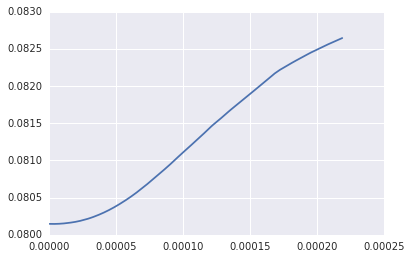

In [1207]:
plt.plot(lcv.alphas_,lcv.mse_path_.mean(1))

In [1214]:
for col,coef in sorted(zip([col for col in mat.columns if 'rank' in col and 'reps' not in col],lcv.coef_),key=lambda x: x[1])[::-1]:
    print col,'%.3f' % coef

tee45_rank 0.114
green0_rank 0.051
tee3_rank 0.045
fairway0_rank 0.038
fairway300_rank 0.034
rough375_rank 0.033
rough90_rank 0.028
green10_rank 0.027
green20_rank 0.026
bunker_rank 0.020
rough0_rank 0.020
fairway540_rank 0.017
other_rank 0.009
green5_rank 0.008


In [1225]:
cats

['tee3',
 'tee45',
 'green0',
 'green5',
 'green10',
 'green20',
 'rough0',
 'rough90',
 'rough375',
 'fairway0',
 'fairway300',
 'fairway540',
 'bunker',
 'other']

In [1226]:
cat_map = {'rough90':'rough30','rough375':'rough125','fairway300':'fairway100','fairway540':'fairway180'}

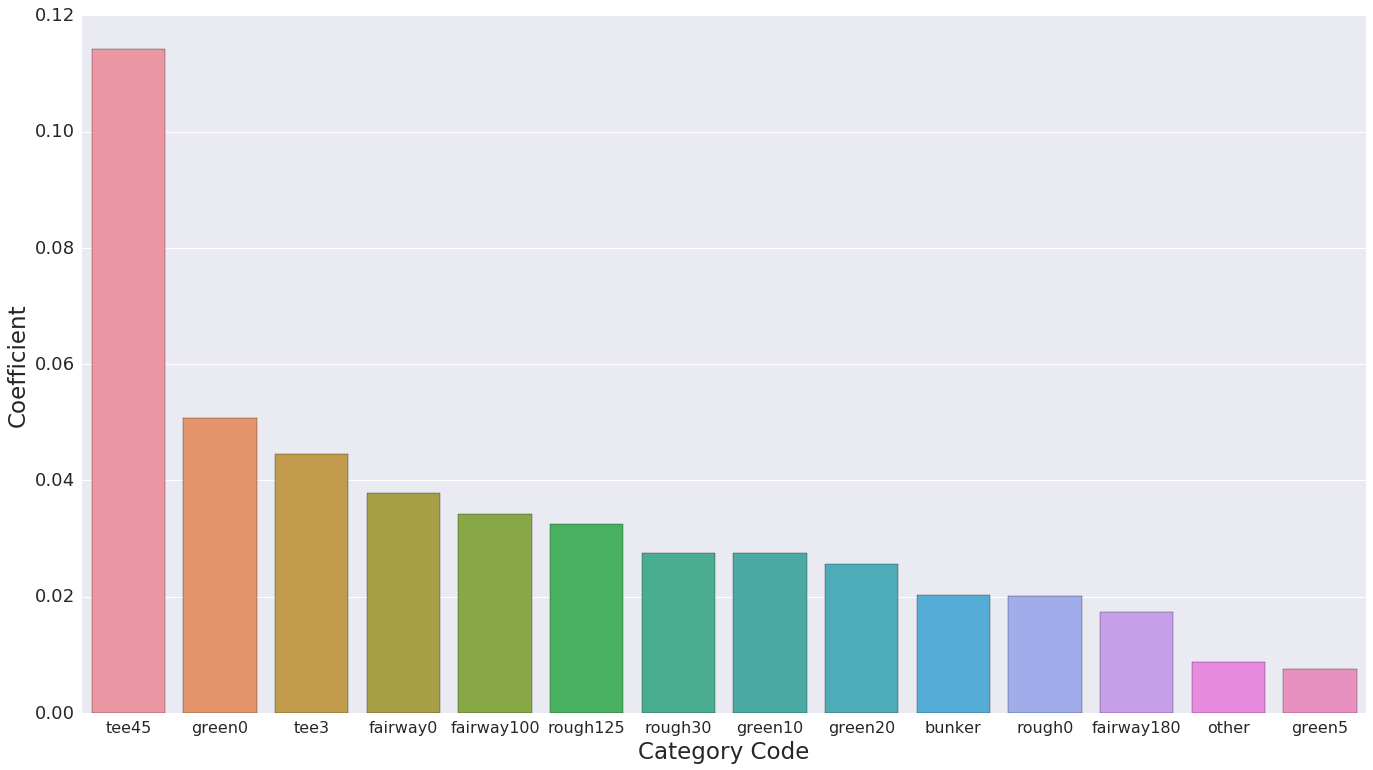

In [1237]:
fig, ax = plt.subplots(1,1, figsize=(23,12.5))
x,y = zip(*sorted(zip([col.split('_')[0] for col in mat.columns if 'rank' in col and 'reps' not in col],lcv.coef_),key=lambda x: x[1])[::-1])
x = [cat_map[cat] if cat in cat_map else cat for cat in x]
plt.setp(ax.get_xticklabels(), fontsize=16);
plt.setp(ax.get_yticklabels(), fontsize=18);
sns.barplot(x,y);
plt.xlabel('Category Code', fontsize = 23);
plt.ylabel('Coefficient', fontsize = 23);
plt.savefig('./../Plots/Importances_predictive.png',dpi=500)

In [446]:
for col,coef in sorted(:
    print col,coef

tee45_rank 0.115458431576
green0_rank 0.0498420346678
tee3_rank 0.0464454978271
fairway0_rank 0.0364075916999
fairway300_rank 0.035492206679
rough375_rank 0.0330417682415
green20_rank 0.0285378797918
rough90_rank 0.0273870768121
green10_rank 0.0264376001186
rough0_rank 0.0257131660192
bunker_rank 0.0202800536568
fairway540_rank 0.0149623000308
green5_rank 0.00977955338543


In [447]:
pd.Series(lcv.predict(X)).describe()

count    24044.000000
mean         0.504097
std          0.054289
min          0.314359
25%          0.468297
50%          0.505575
75%          0.540667
max          0.725616
dtype: float64

In [448]:
pd.Series(np.abs(lcv.predict(X)-y)).describe()

count    24044.000000
mean         0.243701
std          0.143420
min          0.000013
25%          0.120920
50%          0.241293
75%          0.363063
max          0.661860
dtype: float64